In [ ]:
from google.colab import drive 

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import gzip
%matplotlib inline

In [ ]:
## 데이터 불러오기
train = pd.read_csv('/content/gdrive/MyDrive/BOAZ/mini/청와대 청원/train.csv', encoding = 'utf-8')
test = pd.read_csv('/content/gdrive/MyDrive/BOAZ/mini/청와대 청원/test.csv', encoding = 'utf-8')
sample_submission = pd.read_csv('/content/gdrive/MyDrive/BOAZ/mini/청와대 청원/sample_submission.csv', encoding = 'utf-8')

In [ ]:
# 제목, 내용 분리
train_new = pd.read_csv('/content/gdrive/MyDrive/BOAZ/mini/청와대 청원/train_title and data_0216.csv', encoding = 'utf-8')

# 전처리

In [ ]:
## konlpy, mecab 설치
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2023-02-19 07:21:46--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2023-02-19 07:21:46--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca4f1822d20f1dba733f91c6543.dl.dropboxusercontent.com/cd/0/get/B2yFsAJJBidlM7f0ELBFBsUu9F8uEswhbGZIivgGdXo3-yFJlp7lpEhoRgmfyvmW54S1c4NMZDX1uuqqqvcLjVz_R_gnUBw38lxW_aq_vW67c-qNJGx0QfnV-Pz_PYrPI7PsBMeSLvjThdg0S7BAjz8Fs8pAr7C5w3x6kql1vaB5DV2GkdZ7aE3q-BbOTzNP4PY/file?dl=1# [following]
--2023-02-19 07:21:46--  https://uca4f1822d20f1dba733f91c6543.dl.dropboxusercontent.com/cd/0/get/B2yFsAJJBidl

In [ ]:
from konlpy.tag import Okt, Mecab

okt = Okt()
mecab = Mecab()

## 결측치, 불용어 제거

In [ ]:
np.sum(train.isnull())

index       0
category    0
data        8
dtype: int64

In [ ]:
train.dropna(axis=0, inplace=True)

In [ ]:
np.sum(test.isnull())

index    0
data     0
dtype: int64

In [ ]:
train['data'] = train['data'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test['data'] = test['data'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# 특수문자 제거
train['data'] = train['data'].str.replace(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\\n\t]+', " ", regex=True)
test['data'] = test['data'].str.replace(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', " ", regex=True)
train['data'] = train['data'].str.replace(r'\t+', " ", regex=True)
test['data'] = test['data'].str.replace(r'\t+', " ", regex=True)
train['data'] = train['data'].str.replace(r'[\\n]+'," ", regex=True)
test['data'] = test['data'].str.replace(r'[\\n]+'," ", regex=True)

<ipython-input-10-709a20f71fbe>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['data'] = train['data'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-10-709a20f71fbe>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test['data'] = test['data'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


## 내용 길이 파악

train data의 최소 길이 :  1
train data의 최대 길이 :  28481
train data의 평균 길이 :  499.629300860172


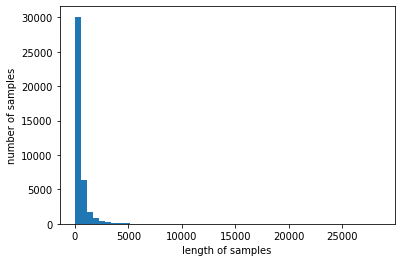

In [ ]:
print('train data의 최소 길이 : ', min(map(len, train['data'])))
print('train data의 최대 길이 : ', max(map(len, train['data'])))
print('train data의 평균 길이 : ', sum(map(len, train['data'])) / len(train['data']))
plt.hist([len(s) for s in train['data']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

test data의 최소 길이 :  8
test data의 최대 길이 :  22394
test data의 평균 길이 :  502.223


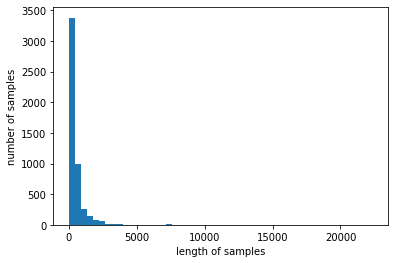

In [ ]:
print('test data의 최소 길이 : ', min(map(len, test['data'])))
print('test data의 최대 길이 : ', max(map(len, test['data'])))
print('test data의 평균 길이 : ', sum(map(len, test['data'])) / len(test['data']))
plt.hist([len(s) for s in test['data']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
## 가장 짧은 문장은 삭제(길이=1)
pop_index = list(np.where(train['data'].apply(len)==1)[0])

In [ ]:
train.drop(pop_index,inplace=True)
train.reset_index(inplace=True,drop=True)

In [ ]:
## 그 다음으로 짧은 문장 삭제(길이=3)
pop_index = list(np.where(train['data'].apply(len)==3)[0])
train.drop(pop_index,inplace=True)
train.reset_index(inplace=True,drop=True)

In [ ]:
# 어떤 문장이 가장 짧고, 긴지 
max_list = []
min_list = []

for line in train['data']:
  if len(line) == max(map(len, train['data'])):
    max_list.append(line)
  
  if len(line) == min(map(len, train['data'])):
    min_list.append(line)

In [ ]:
min_list

[' ', ' ', ' ', ' ', ' ']

In [ ]:
max_list

['청소년 보호법이 아닌 소년법을 개정해주세요청소년 보호법은 다른 법입니다 베스트 청원중 청소년 보호법 폐지에 관한 글이 있습니다그러나 청소년 보호법에 대해 잘못 생각하시는 분들이 많으신데 청소년 보호법을 살펴보자면 청소년 보호법을 유해한 환경에서 구제하는 법령입니다아래의 청소년 보호법의 목적을 보시면 알 수 있습니다참고로 버튼이라고 쓰여져 있는 곳은 복사 붙여넣기를 한 관계로 양해해 주셨으면 합니다시행  법률 제호  일부개정 공포법령보기여성가족부청소년보호환경과 제장 총칙제조목적 이 법은 청소년에게 유해한 매체물과 약물 등이 청소년에게 유통되는 것과 청소년이 유해한 업소에 출입하는 것 등을 규제하고 청소년을 유해한 환경으로부터 보호구제함으로써 청소년이 건전한 인격체로 성장할 수 있도록 함을 목적으로 한다제조정의 이 법에서 사용하는 용어의 뜻은 다음과 같다  개정      청소년이란 만 세 미만인 사람을 말한다 다만 만 세가 되는 해의 월 일을 맞이한 사람은 제외한다 매체물이란 다음 각 목의 어느 하나에 해당하는 것을 말한다가 영화 및 비디오물의 진흥에 관한 법률에 따른 영화 및 비디오물나 게임산업진흥에 관한 법률에 따른 게임물다 음악산업진흥에 관한 법률에 따른 음반 음악파일 음악영상물 및 음악영상파일라 공연법에 따른 공연국악공연은 제외한다마 전기통신사업법에 따른 전기통신을 통한 부호문언음향 또는 영상정보바 방송법에 따른 방송프로그램보도 방송프로그램은 제외한다사 신문 등의 진흥에 관한 법률에 따른 일반일간신문주로 정치경제사회에 관한 보도논평 및 여론을 전파하는 신문은 제외한다 특수일간신문경제산업과학종교 분야는 제외한다 일반주간신문정치경제 분야는 제외한다 특수주간신문경제산업과학시사종교 분야는 제외한다 인터넷신문주로 정치경제사회에 관한 보도논평 및 여론을 전파하는 신문은 제외한다 및 인터넷뉴스서비스아 잡지 등 정기간행물의 진흥에 관한 법률에 따른 잡지정치경제사회시사산업과학종교 분야는 제외한다 정보간행물 전자간행물 및 그 밖의 간행물자 출판문화산업 진흥법에 따른 간행

## 워드클라우드

In [ ]:
# 워드클라우드, 카테고리별로
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

In [ ]:
train2 = train[train['category']==2]
train1 = train[train['category']==1]
train0 = train[train['category']==0]

In [ ]:
train2.reset_index(inplace=True,drop=True)
train1.reset_index(inplace=True,drop=True)
train0.reset_index(inplace=True,drop=True)

In [ ]:
## 명사만 추출
train2_nouns = train2['data'].apply(mecab.nouns) # 13358
train1_nouns = train1['data'].apply(mecab.nouns) # 13335
train0_nouns = train0['data'].apply(mecab.nouns) # 13299

In [ ]:
train0_noun_list = []
train1_noun_list = []
train2_noun_list = []

for i in range(len(train2_nouns)):
  if i < len(train1_nouns):
    train1_noun_list += train1_nouns[i]
  if i < len(train0_nouns):
    train0_noun_list += train0_nouns[i]

  train2_noun_list += train2_nouns[i]

### 명사

#### category가 0인 경우

In [ ]:
c0 = Counter(train0_noun_list)
c0.most_common(100)

[('것', 22735),
 ('수', 15302),
 ('여성', 13762),
 ('사람', 10931),
 ('일', 9692),
 ('생각', 9273),
 ('말', 8143),
 ('저', 8032),
 ('국민', 7891),
 ('법', 7883),
 ('년', 7529),
 ('처벌', 6974),
 ('사건', 6830),
 ('등', 6057),
 ('인권', 6056),
 ('남성', 6052),
 ('피해자', 5923),
 ('나라', 5890),
 ('이', 5629),
 ('사회', 5444),
 ('폐지', 5335),
 ('청원', 5079),
 ('우리', 5030),
 ('청소년', 4884),
 ('대한민국', 4716),
 ('남자', 4557),
 ('국가', 4475),
 ('여자', 4390),
 ('범죄', 4363),
 ('때', 4163),
 ('문제', 4049),
 ('대통령', 4012),
 ('평등', 3943),
 ('경찰', 3869),
 ('제', 3866),
 ('게', 3722),
 ('중', 3714),
 ('이유', 3575),
 ('거', 3524),
 ('가족', 3516),
 ('가해자', 3500),
 ('아이', 3417),
 ('성', 3351),
 ('그', 3291),
 ('시간', 3181),
 ('때문', 3144),
 ('이상', 3077),
 ('조사', 3042),
 ('학생', 3016),
 ('분', 2937),
 ('학교', 2900),
 ('차별', 2872),
 ('원', 2847),
 ('글', 2830),
 ('경우', 2826),
 ('피해', 2804),
 ('수사', 2790),
 ('정부', 2781),
 ('자신', 2756),
 ('보호', 2731),
 ('만', 2730),
 ('폭행', 2680),
 ('필요', 2581),
 ('번', 2540),
 ('의무', 2486),
 ('사실', 2421),
 ('내용', 2396),
 ('명',

#### 불용어 다시 제거

In [ ]:
remove_set = {'것','수','말','저','등','이','때','제','게','중','거','그','때문','분','원','경우','만','명','내','후','건','월','전','부','나','하나','저희'}

train0_noun_new = [i for i in train0_noun_list if i not in remove_set]

In [ ]:
with gzip.open('train0_noun.pickle', 'wb') as f:
    pickle.dump(train0_noun_new, f)

In [ ]:
%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
import matplotlib as mpl

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager._rebuild()

The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 128126 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20180306-3_all.deb ...
Unpacking fonts-nanum (20180306-3) ...
Setting up fonts-nanum (20180306-3) ...
Processing triggers for fontconfig (2.13.1-2ubuntu3) ...


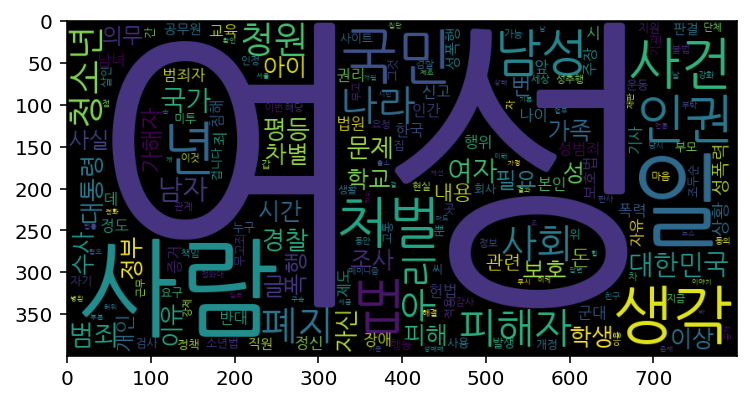

In [ ]:
c0_new = Counter(train0_noun_new)
wc = WordCloud(font_path='NanumGothic.ttf',scale=2.0, max_font_size=200)
gen = wc.generate_from_frequencies(c0_new)
plt.figure()
plt.imshow(gen)

#### category가 1인 경우

In [ ]:
c1 = Counter(train1_noun_list)
c1.most_common(100)

[('것', 18226),
 ('선수', 13518),
 ('수', 12819),
 ('국민', 9136),
 ('생각', 7790),
 ('사람', 6795),
 ('우리', 6397),
 ('일', 5965),
 ('년', 5810),
 ('방송', 5730),
 ('국가', 5515),
 ('올림픽', 5416),
 ('나라', 5210),
 ('말', 5127),
 ('등', 5050),
 ('청원', 4843),
 ('대표', 4819),
 ('축구', 4680),
 ('대한민국', 4254),
 ('이', 4198),
 ('게임', 4096),
 ('한국', 4006),
 ('문제', 3721),
 ('감독', 3556),
 ('저', 3496),
 ('팀', 3469),
 ('정부', 3421),
 ('언론', 3325),
 ('때', 3232),
 ('거', 3141),
 ('문화', 3115),
 ('대통령', 3024),
 ('기사', 2909),
 ('경기', 2880),
 ('스포츠', 2780),
 ('원', 2759),
 ('게', 2729),
 ('협회', 2703),
 ('연맹', 2625),
 ('뉴스', 2495),
 ('때문', 2483),
 ('중', 2477),
 ('조사', 2452),
 ('글', 2420),
 ('이상', 2419),
 ('그', 2267),
 ('처벌', 2263),
 ('분', 2239),
 ('만', 2181),
 ('번', 2148),
 ('시간', 2144),
 ('필요', 2121),
 ('이번', 2085),
 ('세계', 2021),
 ('돈', 1980),
 ('전', 1976),
 ('평창', 1975),
 ('법', 1950),
 ('건', 1937),
 ('이유', 1906),
 ('관련', 1899),
 ('사건', 1883),
 ('반대', 1861),
 ('제', 1853),
 ('빙상', 1852),
 ('경우', 1844),
 ('단일팀', 1795),
 ('사용', 17

#### 불용어 다시 제거

In [ ]:
remove_set = {'것','수','일','년','등','이','저','때','거','원','게','중','그','분','만','번','전','건','제','명','월','데'}

train1_noun_new = [i for i in train1_noun_list if i not in remove_set]

In [ ]:
with gzip.open('train1_noun.pickle', 'wb') as f:
    pickle.dump(train1_noun_new, f)

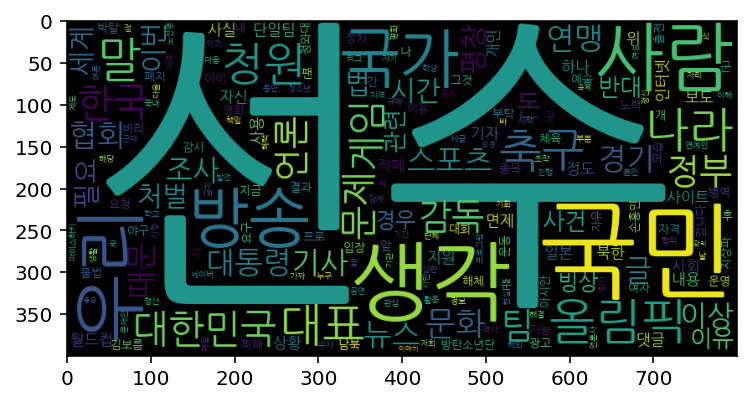

In [ ]:
c1_new = Counter(train1_noun_new)

wc = WordCloud(font_path='NanumGothic.ttf',scale=2.0, max_font_size=200)
gen = wc.generate_from_frequencies(c1_new)
plt.figure()
plt.imshow(gen)

#### category가 2인 경우

In [ ]:
c2 = Counter(train2_noun_list)
c2.most_common(100)

[('것', 24125),
 ('수', 21888),
 ('아이', 21793),
 ('학교', 18173),
 ('학생', 16157),
 ('교육', 16025),
 ('교사', 11653),
 ('생각', 11553),
 ('일', 10025),
 ('저', 7887),
 ('시간', 7873),
 ('년', 7117),
 ('우리', 6895),
 ('유치원', 6894),
 ('말', 6870),
 ('어린이집', 6817),
 ('문제', 6550),
 ('등', 6438),
 ('부모', 6190),
 ('사람', 6001),
 ('대학', 5809),
 ('나라', 5459),
 ('때', 5451),
 ('선생', 5056),
 ('중', 4605),
 ('원', 4344),
 ('거', 4285),
 ('법', 4284),
 ('폐지', 4128),
 ('때문', 4106),
 ('제도', 4095),
 ('제', 4021),
 ('이', 3986),
 ('지원', 3965),
 ('정책', 3828),
 ('초등', 3824),
 ('공부', 3816),
 ('필요', 3761),
 ('보육', 3760),
 ('국민', 3744),
 ('저희', 3702),
 ('게', 3680),
 ('사회', 3678),
 ('청소년', 3612),
 ('시험', 3557),
 ('청원', 3551),
 ('수업', 3550),
 ('수능', 3471),
 ('국가', 3443),
 ('만', 3410),
 ('평가', 3359),
 ('경우', 3284),
 ('정부', 3246),
 ('후', 3156),
 ('영어', 3149),
 ('엄마', 3137),
 ('돈', 3137),
 ('명', 3020),
 ('학부모', 2962),
 ('이상', 2944),
 ('번', 2832),
 ('가정', 2830),
 ('이유', 2791),
 ('대한민국', 2763),
 ('시', 2724),
 ('집', 2712),
 ('고등학교', 2711),

#### 불용어 다시 제거

In [ ]:
remove_set = {'것','수','일','저','년','등','때','중','원','거','때문','이','게','만','후','명','번','분','월','전','데'}

train2_noun_new = [i for i in train2_noun_list if i not in remove_set]

In [ ]:
with gzip.open('train2_noun.pickle', 'wb') as f:
    pickle.dump(train2_noun_new, f)

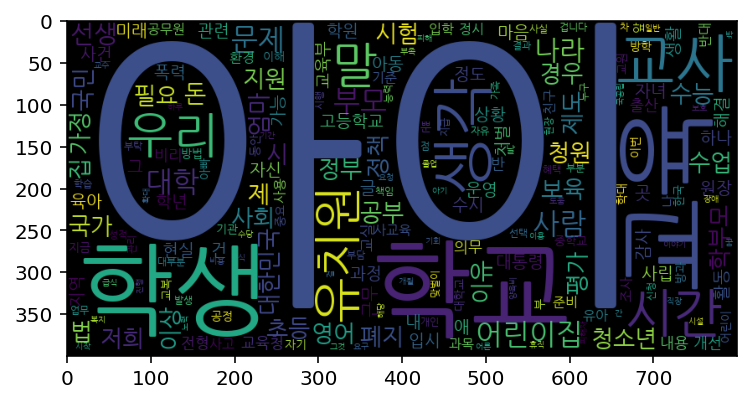

In [ ]:
c2_new = Counter(train2_noun_new)

wc = WordCloud(font_path='NanumGothic.ttf',scale=2.0, max_font_size=200)
gen = wc.generate_from_frequencies(c2_new)
plt.figure()
plt.imshow(gen)

### 명사, 동사, 형용사

In [ ]:
## 명사, 동사, 형용사
# http://openuiz.blogspot.com/2016/07/mecab-ko-dic.html
# https://wikidocs.net/33799

train_list_new = []

for document in train['data']:
    mecab = Mecab()
    for word in mecab.pos(document):
        if word[1] in ['NNG','NNP','NNB','NNBC','VV','VA','MM','MAG','XR']: #명사, 동사, 형용사
            train_list_new.append(word[0])

In [ ]:
Counter(train_list_new).most_common(100)

[('하', 80027),
 ('있', 67060),
 ('것', 65084),
 ('수', 50155),
 ('없', 41982),
 ('되', 33011),
 ('생각', 28616),
 ('받', 27303),
 ('아이', 26274),
 ('안', 23904),
 ('사람', 23727),
 ('학교', 21893),
 ('그', 21026),
 ('일', 21023),
 ('국민', 20771),
 ('말', 20663),
 ('년', 20547),
 ('한', 20111),
 ('학생', 20080),
 ('이', 20037),
 ('교육', 18546),
 ('많', 17684),
 ('등', 17545),
 ('같', 17008),
 ('나라', 16549),
 ('보', 16194),
 ('더', 15597),
 ('여성', 15381),
 ('문제', 14320),
 ('다', 14165),
 ('법', 14117),
 ('선수', 14027),
 ('청원', 13473),
 ('국가', 13433),
 ('시간', 13198),
 ('좋', 13016),
 ('때', 12862),
 ('이런', 12692),
 ('교사', 12586),
 ('대한민국', 11733),
 ('처벌', 11610),
 ('사건', 11054),
 ('거', 10899),
 ('사회', 10896),
 ('중', 10798),
 ('폐지', 10776),
 ('지금', 10159),
 ('전', 9811),
 ('원', 9783),
 ('때문', 9733),
 ('대통령', 9667),
 ('정부', 9448),
 ('청소년', 9403),
 ('만들', 9294),
 ('왜', 9120),
 ('못', 8942),
 ('너무', 8542),
 ('알', 8541),
 ('필요', 8463),
 ('이상', 8447),
 ('이유', 8272),
 ('부모', 7984),
 ('경우', 7954),
 ('분', 7884),
 ('다른', 7825),
 ('가'

In [ ]:
remove_set = {'하','있','것','수','그','이','때','거','때문','왜','들','또'}

train_token_new = [i for i in train_list_new if i not in remove_set]

In [ ]:
with gzip.open('train_token.pickle', 'wb') as f:
    pickle.dump(train_token_new, f)

In [ ]:
with gzip.open('train_token.pickle','rb') as f:
    train_token = pickle.load(f)

#### category가 2인 경우

In [ ]:
train2_list_new = []

for document in train2['data']:
    mecab = Mecab()
    for word in mecab.pos(document):
        if word[1] in ['NNG','NNP','NNB','NNBC','VV','VA','MM','MAG','XR']: #명사, 동사, 형용사
            train2_list_new.append(word[0])

In [ ]:
Counter(train2_list_new).most_common(100)

[('하', 32087),
 ('있', 27821),
 ('것', 24125),
 ('수', 21942),
 ('아이', 21753),
 ('학교', 18173),
 ('학생', 16157),
 ('교육', 16025),
 ('없', 15944),
 ('되', 13627),
 ('교사', 11653),
 ('생각', 11553),
 ('받', 10688),
 ('안', 9535),
 ('일', 8369),
 ('시간', 7873),
 ('한', 7768),
 ('많', 7542),
 ('그', 7227),
 ('년', 7152),
 ('말', 7083),
 ('유치원', 6894),
 ('어린이집', 6817),
 ('이', 6681),
 ('더', 6561),
 ('문제', 6550),
 ('등', 6438),
 ('같', 6325),
 ('부모', 6190),
 ('사람', 6001),
 ('대학', 5809),
 ('좋', 5795),
 ('보', 5467),
 ('나라', 5457),
 ('때', 5452),
 ('다', 5416),
 ('선생', 5056),
 ('이런', 4619),
 ('중', 4606),
 ('법', 4284),
 ('원', 4269),
 ('거', 4268),
 ('폐지', 4128),
 ('때문', 4106),
 ('제도', 4093),
 ('너무', 3974),
 ('지원', 3965),
 ('지금', 3883),
 ('정책', 3828),
 ('초등', 3824),
 ('공부', 3817),
 ('못', 3802),
 ('필요', 3761),
 ('보육', 3760),
 ('국민', 3744),
 ('사회', 3678),
 ('청소년', 3612),
 ('잘', 3590),
 ('시험', 3557),
 ('청원', 3551),
 ('수업', 3550),
 ('가', 3518),
 ('만들', 3508),
 ('수능', 3471),
 ('국가', 3443),
 ('평가', 3359),
 ('현재', 3344),
 ('경우',

In [ ]:
remove_set = {'하','있','것','수','그','이','때','거','가','때문','왜','들','또'}

train2_token_new = [i for i in train2_list_new if i not in remove_set]

In [ ]:
with gzip.open('train2_token.pickle', 'wb') as f:
    pickle.dump(train2_token_new, f)

#### category가 1인 경우

In [ ]:
train1_list_new = []

for document in train1['data']:
    mecab = Mecab()
    for word in mecab.pos(document):
        if word[1] in ['NNG','NNP','NNB','NNBC','VV','VA','MM','MAG','XR']: #명사, 동사, 형용사
            train1_list_new.append(word[0])

In [ ]:
Counter(train1_list_new).most_common(100)

[('하', 20361),
 ('것', 18224),
 ('있', 17750),
 ('선수', 13518),
 ('수', 12871),
 ('없', 10876),
 ('국민', 9136),
 ('되', 8715),
 ('생각', 7790),
 ('사람', 6795),
 ('안', 6203),
 ('년', 5825),
 ('그', 5748),
 ('방송', 5730),
 ('보', 5716),
 ('한', 5662),
 ('이', 5563),
 ('국가', 5515),
 ('받', 5509),
 ('올림픽', 5416),
 ('말', 5266),
 ('많', 5217),
 ('나라', 5207),
 ('등', 5050),
 ('청원', 4843),
 ('같', 4834),
 ('대표', 4819),
 ('축구', 4680),
 ('일', 4611),
 ('대한민국', 4254),
 ('게임', 4096),
 ('다', 4043),
 ('좋', 4020),
 ('한국', 4006),
 ('더', 3919),
 ('문제', 3721),
 ('감독', 3556),
 ('전', 3509),
 ('이런', 3471),
 ('팀', 3469),
 ('정부', 3421),
 ('언론', 3325),
 ('때', 3238),
 ('거', 3122),
 ('문화', 3115),
 ('대통령', 3024),
 ('지금', 3023),
 ('기사', 2909),
 ('경기', 2880),
 ('스포츠', 2780),
 ('협회', 2703),
 ('원', 2702),
 ('만들', 2674),
 ('연맹', 2625),
 ('뉴스', 2495),
 ('때문', 2483),
 ('중', 2478),
 ('조사', 2452),
 ('이상', 2421),
 ('글', 2421),
 ('처벌', 2263),
 ('왜', 2258),
 ('분', 2239),
 ('다른', 2231),
 ('알', 2199),
 ('못', 2199),
 ('시간', 2144),
 ('번', 2132),
 (

In [ ]:
remove_set = {'하','있','것','수','그','이','때','거','가','때문','왜','들','또','다'}

train1_token_new = [i for i in train1_list_new if i not in remove_set]

In [ ]:
with gzip.open('train1_token.pickle', 'wb') as f:
    pickle.dump(train1_token_new, f)

#### category가 0인 경우

In [ ]:
train0_list_new = []

for document in train0['data']:
    mecab = Mecab()
    for word in mecab.pos(document):
        if word[1] in ['NNG','NNP','NNB','NNBC','VV','VA','MM','MAG','XR']: #명사, 동사, 형용사
            train0_list_new.append(word[0])

In [ ]:
Counter(train0_list_new).most_common(100)

[('하', 27579),
 ('것', 22735),
 ('있', 21489),
 ('수', 15342),
 ('없', 15162),
 ('여성', 13762),
 ('받', 11106),
 ('사람', 10931),
 ('되', 10669),
 ('생각', 9273),
 ('말', 8314),
 ('안', 8166),
 ('그', 8051),
 ('일', 8043),
 ('국민', 7891),
 ('법', 7883),
 ('이', 7793),
 ('년', 7570),
 ('처벌', 6974),
 ('사건', 6830),
 ('한', 6681),
 ('등', 6057),
 ('인권', 6056),
 ('남성', 6052),
 ('피해자', 5923),
 ('나라', 5885),
 ('같', 5849),
 ('사회', 5444),
 ('폐지', 5335),
 ('더', 5117),
 ('청원', 5079),
 ('보', 5011),
 ('많', 4925),
 ('청소년', 4884),
 ('대한민국', 4716),
 ('다', 4706),
 ('이런', 4602),
 ('남자', 4557),
 ('국가', 4475),
 ('여자', 4390),
 ('범죄', 4363),
 ('때', 4172),
 ('문제', 4049),
 ('대통령', 4012),
 ('평등', 3943),
 ('경찰', 3869),
 ('중', 3714),
 ('왜', 3647),
 ('이유', 3575),
 ('가족', 3516),
 ('거', 3509),
 ('가해자', 3500),
 ('아이', 3412),
 ('성', 3351),
 ('지금', 3253),
 ('전', 3213),
 ('좋', 3201),
 ('시간', 3181),
 ('때문', 3144),
 ('살', 3123),
 ('만들', 3112),
 ('사실', 3080),
 ('이상', 3079),
 ('알', 3076),
 ('조사', 3042),
 ('학생', 3016),
 ('못', 2941),
 ('분', 2938

In [ ]:
remove_set = {'하','있','것','수','그','이','때','거','가','때문','왜','들','또','다'}

train0_token_new = [i for i in train0_list_new if i not in remove_set]

In [ ]:
with gzip.open('train0_token.pickle', 'wb') as f:
    pickle.dump(train0_token_new, f)

## LDA 토픽 모델링(명사만)
- https://heytech.tistory.com/401  
- https://velog.io/@mare-solis/LDA-%ED%86%A0%ED%94%BD-%EB%AA%A8%EB%8D%B8%EB%A7%81%EC%9C%BC%EB%A1%9C-%EC%BD%98%ED%85%90%EC%B8%A0-%EB%A6%AC%EB%B7%B0%EB%A5%BC-%EB%B6%84%EC%84%9D%ED%95%98%EC%9E%90
---
- https://github.com/ukairia777/bert-topic-models

In [ ]:
from gensim import corpora # 단어 빈도수 계산 패키지
import gensim # LDA 모델 활용 목적
import pyLDAvis.gensim_models as gensimvis # LDA 시각화용 패키지

In [ ]:
NUM_TOPICS = 10 # 토픽 개수는 하이퍼파라미터
# passes: 딥러닝에서 Epoch와 같은 개념으로, 전체 corpus로 모델 학습 횟수 결정
PASSES = 15

In [ ]:
def lda_modeling(review_prep):
    # 단어 인코딩 및 빈도수 계산
    dictionary = corpora.Dictionary(review_prep)
    corpus = [dictionary.doc2bow(review) for review in review_prep]
    # LDA 모델 학습
    model = gensim.models.ldamodel.LdaModel(corpus, 
                                            num_topics = NUM_TOPICS, 
                                            id2word = dictionary, 
                                            passes = PASSES)
    return model, corpus, dictionary

In [ ]:
def print_topic_prop(topics, RATING):
    topic_values = []
    for topic in topics:
        topic_value = topic[1]
        topic_values.append(topic_value)
    topic_prop = pd.DataFrame({"topic_num" : list(range(1, NUM_TOPICS + 1)), "word_prop": topic_values})
    #topic_prop.to_excel('./result/topic_prop_' + RATING +  '.xlsx')
    #display(topic_prop)
    return topic_prop

In [ ]:
model, corpus, dictionary = lda_modeling([train2_noun_new])
NUM_WORDS = 10

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
RATING = 'pos'
topics = model.print_topics(num_words = NUM_WORDS)
df_train2 = print_topic_prop(topics, RATING)

In [ ]:
df_train2

,topic_num,word_prop
0,1,"0.003*""아이"" + 0.002*""교육"" + 0.002*""학교"" + 0.002*""..."
1,2,"0.002*""아이"" + 0.002*""학교"" + 0.001*""교육"" + 0.001*""..."
2,3,"0.002*""아이"" + 0.001*""학교"" + 0.001*""교육"" + 0.001*""..."
3,4,"0.018*""아이"" + 0.016*""학교"" + 0.014*""학생"" + 0.013*""..."
4,5,"0.001*""학교"" + 0.001*""교육"" + 0.001*""생각"" + 0.001*""..."
5,6,"0.001*""교육"" + 0.001*""학교"" + 0.001*""아이"" + 0.001*""..."
6,7,"0.019*""아이"" + 0.014*""교육"" + 0.014*""학교"" + 0.014*""..."
7,8,"0.003*""아이"" + 0.003*""교육"" + 0.003*""학생"" + 0.003*""..."
8,9,"0.001*""아이"" + 0.001*""학교"" + 0.000*""학생"" + 0.000*""..."
9,10,"0.008*""교육"" + 0.007*""학생"" + 0.006*""학교"" + 0.006*""..."


In [ ]:
import pyLDAvis

lda_visualization = gensimvis.prepare(model, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(lda_visualization, 'file_name.html')

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.display(lda_visualization)

## tokenizer(명사,동사,형용사)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_token_new)

In [ ]:
vocab_size = 30000
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(train_token_new)
X_train = tokenizer.texts_to_sequences(train_token_new)
#X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 500
X_train = pad_sequences(X_train, maxlen = max_len)
#X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
#from tensorflow.keras.utils import to_categorical
#y_train = to_categorical(train['category'])